In [273]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf;
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime
from statsmodels.tsa.stattools import adfuller

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

matplotlib.style.use('ggplot')

In [2]:
def parse_date_month(d):
    parsed = d.split(" ")[0].split("/")
    return parsed[2]+ "-" + parsed[0]

In [3]:
df = pd.read_csv("../data/crimes_in_polygon.csv")
df = df[["ID", "Date", "Year", "Zip"]]
df["Month"] = df["Date"].apply(parse_date_month)
df["Month"] = pd.to_datetime(df["Month"])

Overall crime rate in Chicago

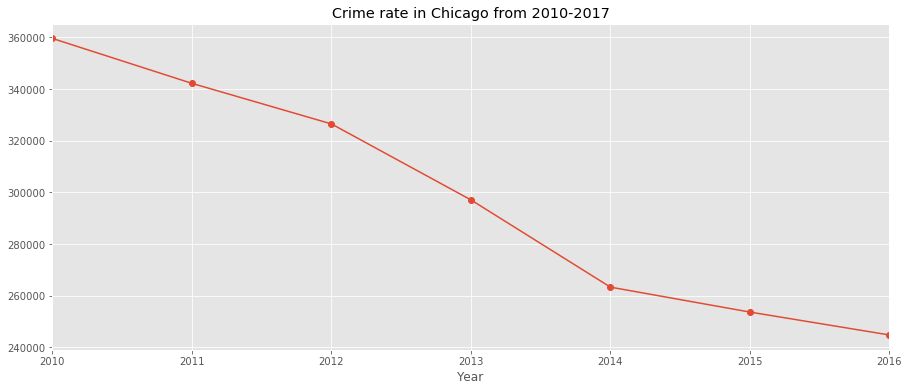

In [4]:
df_by_year = df.groupby("Year").count().ID
df_by_year.plot(title="Crime rate in Chicago from 2010-2016", marker='o')

It seems that the trend in number of crimes is going down. However let's see the same data by monthly.

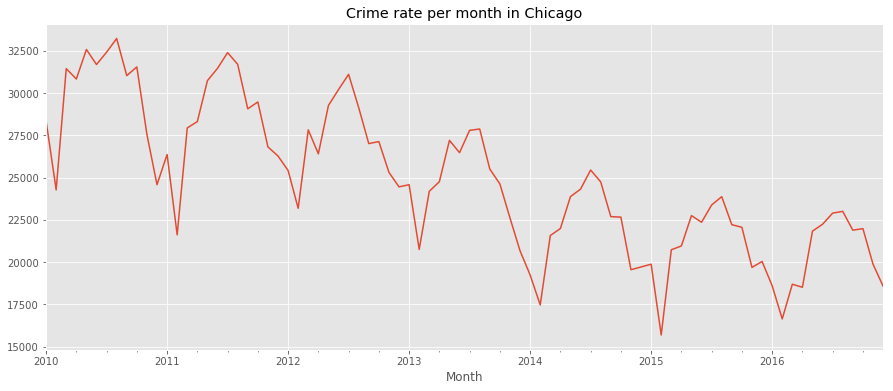

In [5]:
df_by_month = df.groupby("Month").count().ID
df_by_month.plot(title="Crime rate per month in Chicago");

To see months were crime rates were lowest and highest in 2010 and 2016:

In [6]:
df_by_month["2010"].argmin()
df_by_month["2010"].argmax()

df_by_month["2016"].argmin()
df_by_month["2016"].argmax()

Timestamp('2010-02-01 00:00:00')

Timestamp('2010-08-01 00:00:00')

Timestamp('2016-02-01 00:00:00')

Timestamp('2016-08-01 00:00:00')

Interestingly they are exactly same. This phenomena is visible in every year cycle. 

Overall, clearly there exists much more fluctuations when visualizing by months, but the trend still seems to be going down. There also exists seasonal changes, as for example crime rates are lowest after the New Year, but highest around summertime. These times of year, also are coldest/warmest months in Chicago.

Next, to get insight to areal differences, lets compare crime rate in ZIP-codes where it's the minimum, median and maximum.

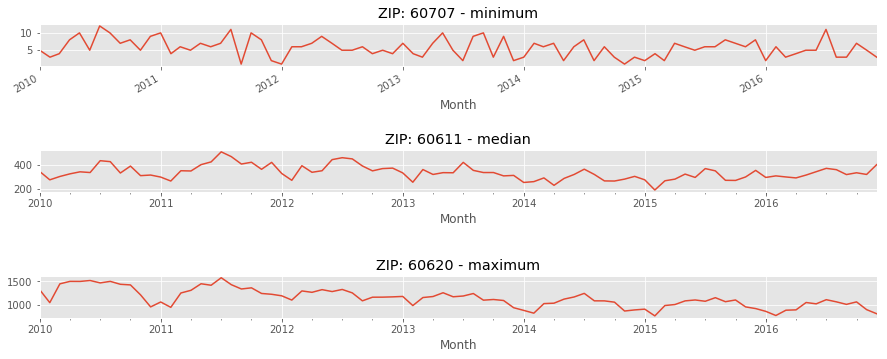

In [7]:
df_z = df.groupby("Zip").count().ID
df_z_m = df.groupby(["Zip", "Month"]).count().ID

min_zip = df_z.argmin()
med_zip = df_z[df_z == df_z.median()].index[0]
max_zip = df_z.argmax()

fig, axes = plt.subplots(nrows=3);
plt.subplots_adjust(hspace = 2);

df_z_m[min_zip].plot(ax=axes[0]);
axes[0].set_title("ZIP: " + str(min_zip) + " - minimum");

df_z_m[med_zip].plot(ax=axes[1]);
axes[1].set_title("ZIP: " + str(med_zip) + " - median");

df_z_m[max_zip].plot(ax=axes[2]);
axes[2].set_title("ZIP: " + str(max_zip) + " - maximum");

Median and maximum crime areas seems to have the same seasonal changes as seen in a big picture. Both lowering when the year has turned, and rising at summer.

To find out how randomized the overall timeseries is, we next plot it via autocorrelation and lag plots.

```
AC is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.
```

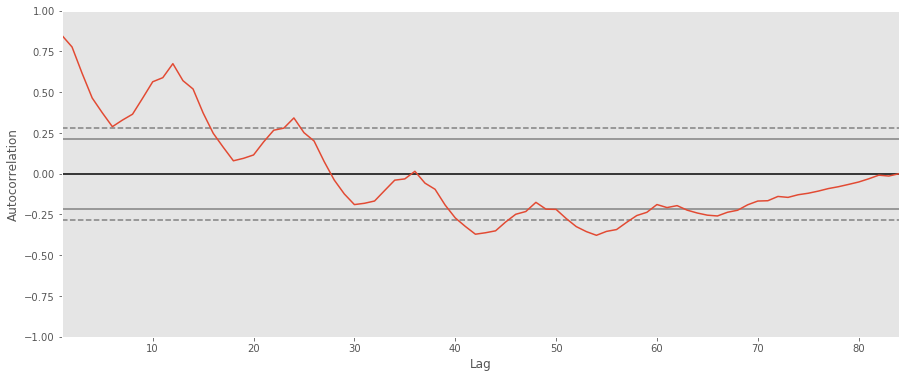

In [8]:
autocorrelation_plot(df_by_month)

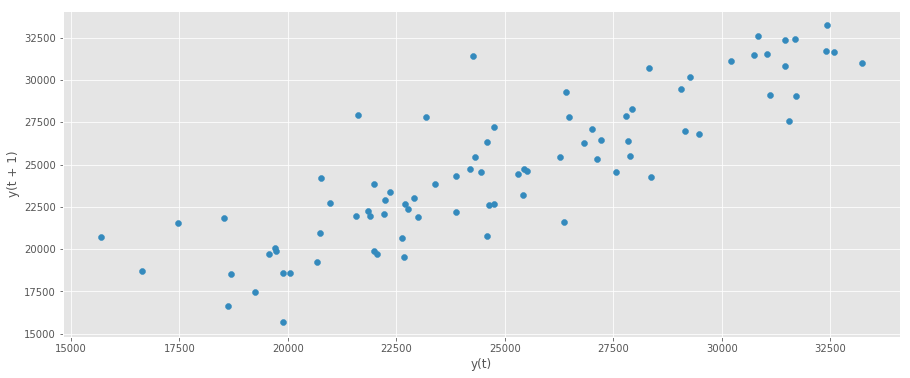

In [9]:
lag_plot(df_by_month)

```
A lag plot checks whether a data set or time series is random or not. Random data should not exhibit any identifiable structure in the lag plot. Non-random structure in the lag plot indicates that the underlying data are not random.
```

From lag plot, we see a some outliers and quite a strong linear autocorrelation between the observation cycles.
To further examine the seasonality and trend, we can plot the decomposed seasonality.

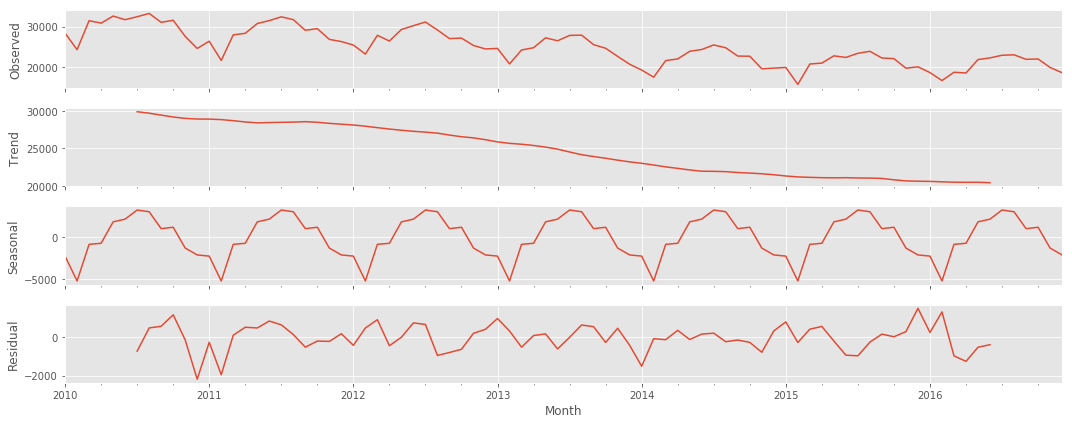

In [50]:
seasonal_dec = sm.tsa.seasonal_decompose(df_by_month)
seasonal_dec.plot();

Now it's starting to look really clear that data has seasonality and a trend which is lowering when time moves forward. We need to take care of this and also stationarize the data i.e. stationarize mean and variance. Thus ordinary linear regression will not work because when running a linear regression the assumption is that all of the observations are all independent of each other.

To get critical values, we next perform the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) and visualize rolling mean and rolling standard deviation.

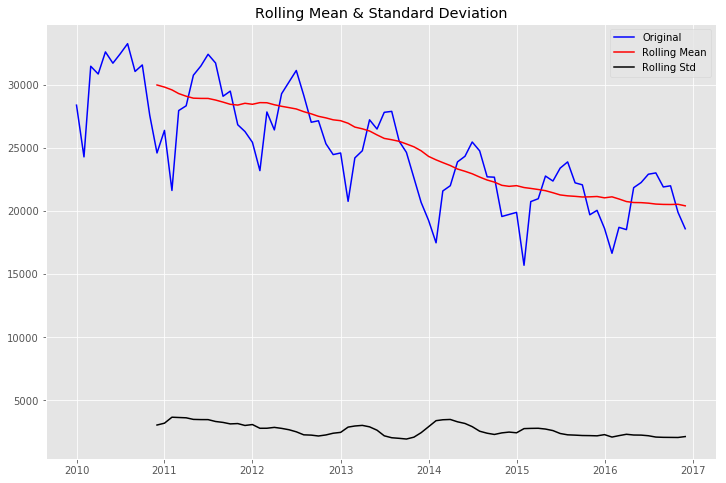

Results of Dickey-Fuller Test:
Test Statistic                 -0.795145
p-value                         0.820544
#Lags Used                     12.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [63]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12);
    rolstd = pd.rolling_std(timeseries, window=12);

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC');
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 
    
test_stationarity(df_by_month);

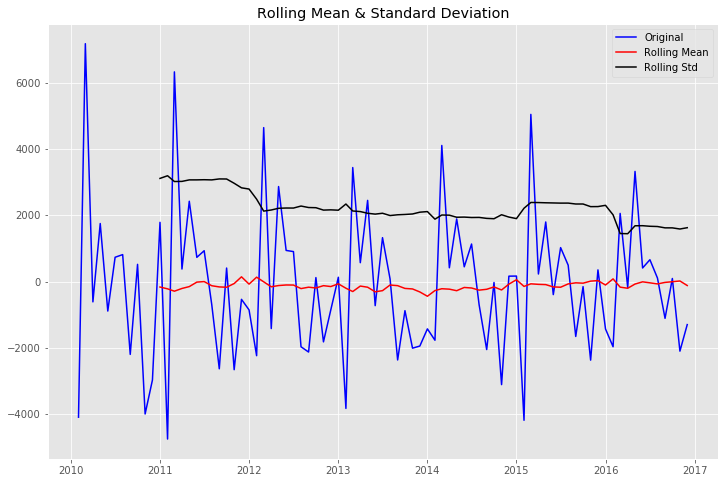

Results of Dickey-Fuller Test:
Test Statistic                 -4.083443
p-value                         0.001031
#Lags Used                     11.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


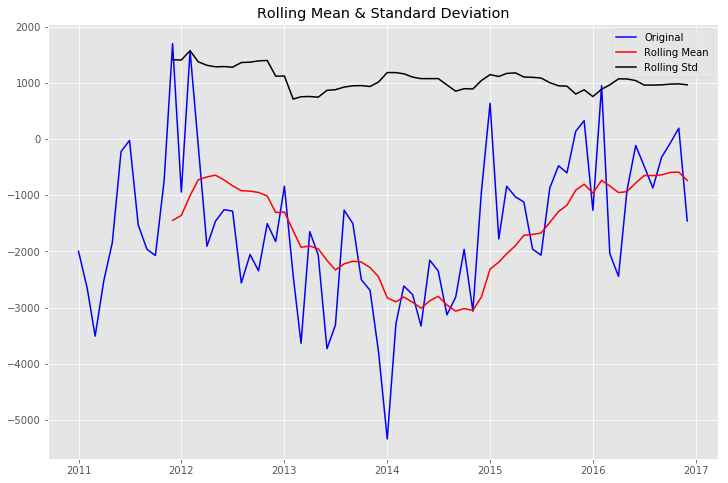

Results of Dickey-Fuller Test:
Test Statistic                 -1.508635
p-value                         0.529235
#Lags Used                     12.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


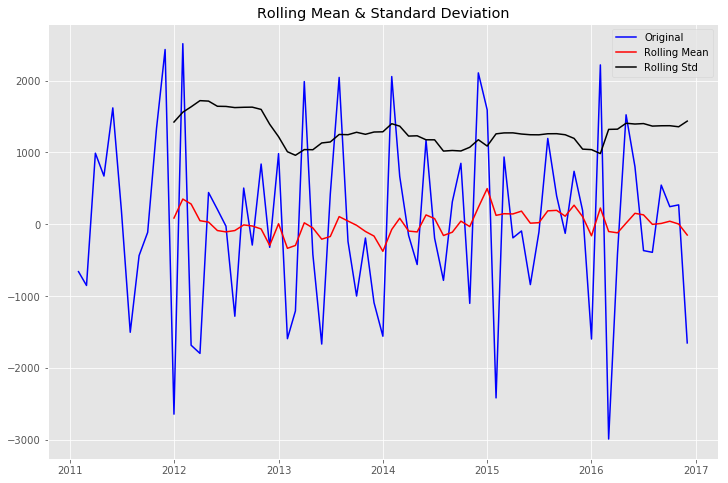

Results of Dickey-Fuller Test:
Test Statistic                 -2.568545
p-value                         0.099674
#Lags Used                     11.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [253]:
# first difference, eliminate strong trend
X = pd.DataFrame(df_by_month)
X["first_difference"] = X.ID - X.ID.shift(1)
test_stationarity(X.first_difference.dropna(inplace=False))

# seasonal diff, eliminate seasons
X["seasonal_difference"] = X.ID - X.ID.shift(12)
test_stationarity(X.seasonal_difference.dropna(inplace=False))

#combine
X["seasonal_first_difference"] = X.first_difference - X.first_difference.shift(12)
test_stationarity(X.seasonal_first_difference.dropna(inplace=False))

P-value has decreased and the dataset has now more statistical meaningfulness to it. We need to determine the tuning parameters for the predictive model next.

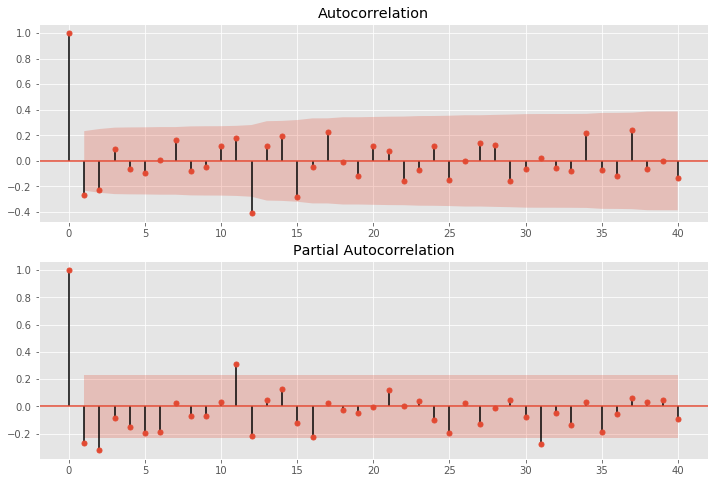

In [258]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [348]:
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

rows = X.shape[0]
months = 12
train, test = X.head(rows), X.tail(months)

In [349]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train.ID,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1559.510518058595
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1060.8474234649123
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1233.417138046719
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1218.8986319910096
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1066.6805355960832
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1051.4132249748138
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1839.433753922478
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1559.7544576020382
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1233.5071645533124
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1010.756660182727
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1596.8204753190805
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1182.7640292590982
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1045.3874331275874
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1011.3668494585212
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1226.8243190831622
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:970.4671600964925
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1199.480330925755
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1179.379350052702

                                 Statespace Model Results                                 
Dep. Variable:                                 ID   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -602.284
Date:                            Fri, 20 Oct 2017   AIC                           1214.568
Time:                                    19:05:38   BIC                           1226.722
Sample:                                01-01-2010   HQIC                          1219.454
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6771      1.935      0.350      0.726      -3.115       4.470
ma.L1         -0.7595      1.919   

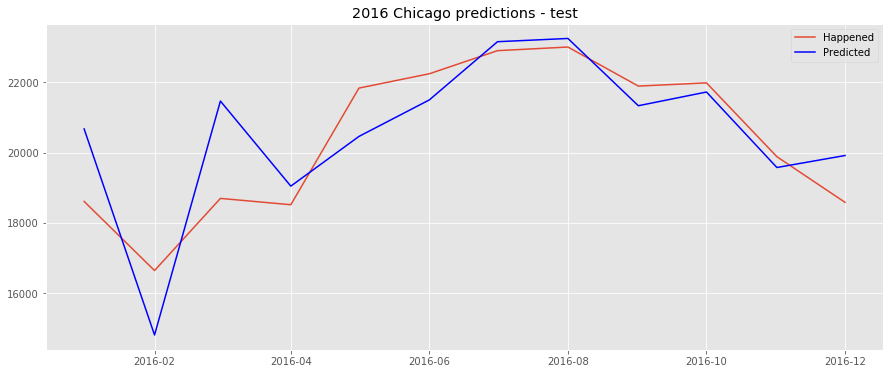

In [472]:
mod = sm.tsa.statespace.SARIMAX(train.ID, trend="n", order=(1,1,1), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())


predictions = results.predict(start=test.index[0], end=test.index[-1], dynamic=False)
error = mean_squared_error(test.ID, predictions)
print('Test MSE: %.3f' % error)

plt_happened, = plt.plot(test.ID, label="Happened");
plt_predicted, = plt.plot(predictions, color='blue', label="Predicted");
plt.title("2016 Chicago predictions - test");
plt.legend([plt_happened, plt_predicted], ['Happened', 'Predicted']);

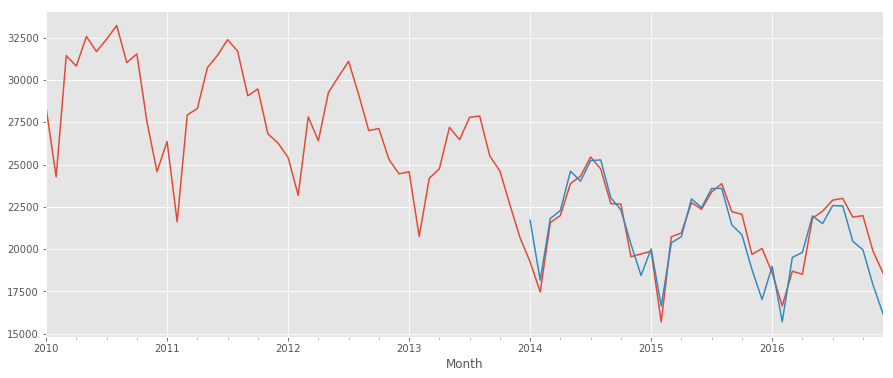

In [473]:
X.ID.plot();
results.predict(start=48, end=83, dynamic=True, full_result=True).plot()

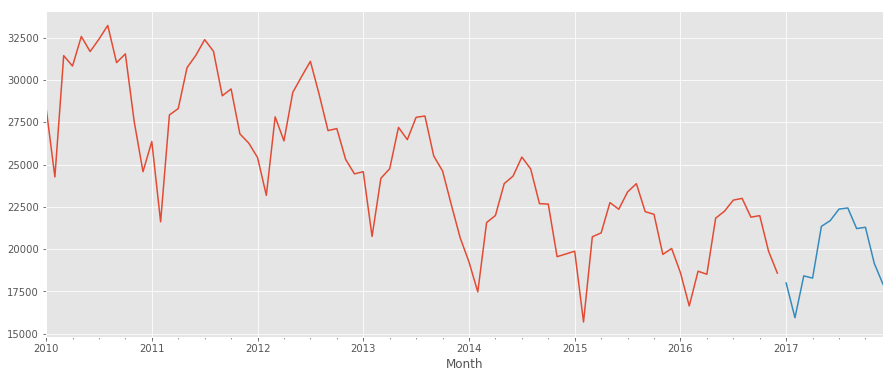

In [474]:
forecasts = results.get_forecast(steps=12).predicted_mean
X.ID.plot()
forecasts.plot()

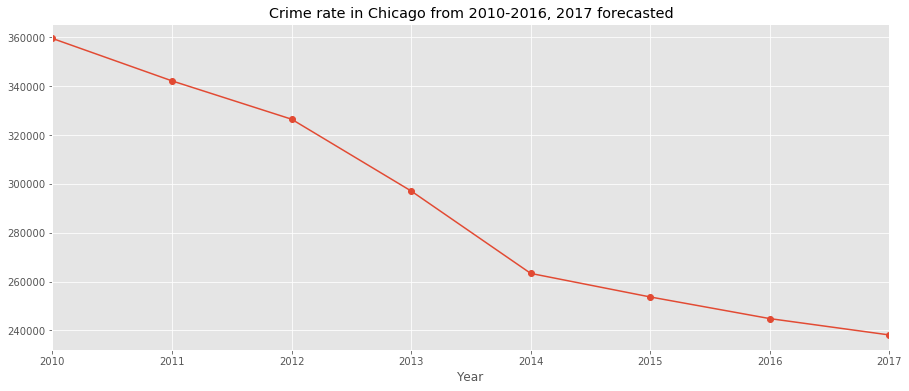

In [475]:
fc_m = round(forecasts.sum())
df_by_year[2017] = fc_m
df_by_year.plot(title="Crime rate in Chicago from 2010-2016, 2017 forecasted", marker='o')